In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, TensorDataset

import pickle

Faces included in the dataset:
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']

The shape of our data is (1560, 62, 47)
We have 1560 images
Each image is of size 62 by 47 pixels


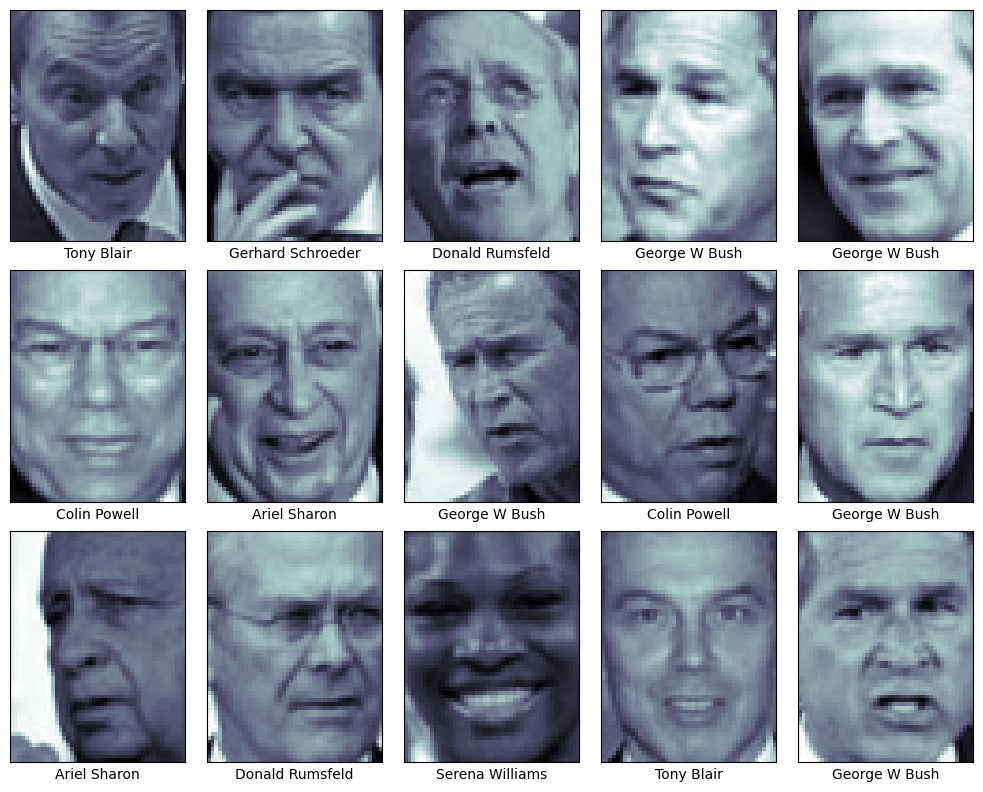

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=50)
print('Faces included in the dataset:')
print(faces.target_names)
print()
print('The shape of our data is {}'.format(faces.images.shape))
print('We have {} images'.format(faces.images.shape[0]))
print('Each image is of size {} by {} pixels'.format(faces.images.shape[1],faces.images.shape[2]))

# Visualize a few of the images
fig, ax = plt.subplots(3, 5, figsize=(10,8))
for i, ax in enumerate(ax.flat):
    ax.imshow(faces.images[i], cmap='bone')
    ax.set(xticks=[], yticks=[],xlabel=faces.target_names[faces.target[i]])
plt.tight_layout()
plt.show()


In [3]:
faces.data

array([[0.3150327 , 0.33333334, 0.39738563, ..., 0.5254902 , 0.606536  ,
        0.46535948],
       [0.11764706, 0.22352941, 0.31764707, ..., 0.303268  , 0.40784314,
        0.52026147],
       [0.3633987 , 0.2535948 , 0.19738562, ..., 0.5189543 , 0.17908497,
        0.3124183 ],
       ...,
       [0.19346406, 0.21045752, 0.29150328, ..., 0.6875817 , 0.6575164 ,
        0.5908497 ],
       [0.5084967 , 0.6       , 0.654902  , ..., 0.9019608 , 0.88366014,
        0.8901961 ],
       [0.12418301, 0.09673203, 0.10849673, ..., 0.12941177, 0.16209151,
        0.29150328]], dtype=float32)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, 
                                                faces.target,random_state=0, 
                                                test_size=0.2)

## Using pytorch to train a neural network on the LFW dataset

In [5]:
import torch.nn as nn

In [6]:
from sklearn.preprocessing import StandardScaler
t = torch.Tensor([[2, 3], [4, 5]])

In [7]:
scaler = StandardScaler()
torch.Tensor(scaler.fit_transform(t))

tensor([[-1., -1.],
        [ 1.,  1.]])

In [8]:
scales = { 'mean': X_train.mean(axis = 0), 'var': X_train.var(axis = 0) }

In [9]:
scales

{'mean': array([0.35294303, 0.36193347, 0.38196024, ..., 0.4561955 , 0.4334069 ,
        0.41012698], dtype=float32),
 'var': array([0.03310091, 0.03149353, 0.03014364, ..., 0.09209338, 0.09187744,
        0.09235296], dtype=float32)}

In [10]:
with open('means.pickle', 'wb') as handle:
    pickle.dump(scales, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
class LFW_Net(nn.Module):
    def __init__(self, n_hidden1, n_hidden2, n_hidden3):
        super().__init__()
        '''
        Constructor for the LFW_Net per the above instructions
        '''
        self.hidden1 = nn.Linear(62 * 47, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden3 = nn.Linear(n_hidden2, n_hidden3)
        self.out = nn.Linear(n_hidden3, 12)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        '''
        Predict method for the LFW_Net per the above instructions
        '''
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        return self.out(x)
    
    def predict(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        return torch.argmax(self.out(x), axis = 1)

In [33]:
torch.float32

torch.float32

In [36]:
net = LFW_Net(n_hidden1=500, n_hidden2=100, n_hidden3=50)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [37]:
torch_X_train = torch.from_numpy(np.array((X_train - scales['mean'])/(scales['var'] + 1e-7)))
torch_y_train = torch.from_numpy(np.array(y_train).reshape(-1, 1))

torch_X_test = torch.from_numpy(np.array((X_test - scales['mean'])/(scales['var'] + 1e-7)))
torch_y_test = torch.from_numpy(np.array(y_test).reshape(-1, 1))

trainset = TensorDataset(torch_X_train, torch_y_train)
testset = TensorDataset(torch_X_test, torch_y_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
net.train() # Set the model to training mode
losses = []
num_iter = 125
for epoch in range(num_iter):
    loss = 0.0
    for i, data in enumerate(trainloader):
        inputs = data[0].to(device)
        labels = data[1].to(device)

        output = net(inputs)
        current_loss = criterion(output, labels.squeeze())
        optimizer.zero_grad()
        loss += current_loss.item()
        current_loss.backward()
        optimizer.step()

    losses.append(loss)
losses

[82.72877848148346,
 62.93330800533295,
 47.77407056093216,
 34.17111927270889,
 25.231578707695007,
 17.381485164165497,
 11.620184004306793,
 9.047563828527927,
 5.694651626050472,
 4.1089240945875645,
 3.02572800219059,
 2.042093524709344,
 1.5333177745342255,
 1.2220089882612228,
 1.02374807279557,
 0.8468560762703419,
 0.7114078663289547,
 0.6238674316555262,
 0.5463544703088701,
 0.489473728928715,
 0.43820950854569674,
 0.3983071371912956,
 0.36303126509301364,
 0.33311554230749607,
 0.3082686453126371,
 0.28591927140951157,
 0.2668662767391652,
 0.2496725143864751,
 0.23428876046091318,
 0.2203289596363902,
 0.20768314297311008,
 0.1969460304826498,
 0.1866274366620928,
 0.17756210744846612,
 0.16908204136416316,
 0.16124745761044323,
 0.1538430971559137,
 0.14757008966989815,
 0.14136749098543078,
 0.13564883393701166,
 0.1304156769765541,
 0.1255495654186234,
 0.12109579099342227,
 0.11679686303250492,
 0.11256419436540455,
 0.10885400313418359,
 0.10528211388736963,
 0.10201

In [15]:
dummy_input = torch.Tensor(faces.images[0].reshape(1, -1))
net.predict(dummy_input).item()

11

In [16]:
import torch.onnx

In [17]:
torch.onnx.export(net, dummy_input, "model.onnx", input_names = ['input'], output_names = ['output'], verbose = True)

Exported graph: graph(%input : Float(1, 2914, strides=[2914, 1], requires_grad=0, device=cpu),
      %hidden1.weight : Float(500, 2914, strides=[2914, 1], requires_grad=1, device=cpu),
      %hidden1.bias : Float(500, strides=[1], requires_grad=1, device=cpu),
      %hidden2.weight : Float(100, 500, strides=[500, 1], requires_grad=1, device=cpu),
      %hidden2.bias : Float(100, strides=[1], requires_grad=1, device=cpu),
      %hidden3.weight : Float(50, 100, strides=[100, 1], requires_grad=1, device=cpu),
      %hidden3.bias : Float(50, strides=[1], requires_grad=1, device=cpu),
      %out.weight : Float(12, 50, strides=[50, 1], requires_grad=1, device=cpu),
      %out.bias : Float(12, strides=[1], requires_grad=1, device=cpu)):
  %/hidden1/Gemm_output_0 : Float(1, 500, strides=[500, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/hidden1/Gemm"](%input, %hidden1.weight, %hidden1.bias), scope: __main__.LFW_Net::/torch.nn.modules.linear.Linear::hid

## Inference

In [18]:
with open('means.pickle', 'rb') as handle:
    means = pickle.load(handle)

In [20]:
test_input = (dummy_input.numpy() - means['mean']) / (means['var'] + 1e-6)

In [23]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
ort_session = ort.InferenceSession("model.onnx")

# Create input data (numpy array)

# Run inference
outputs = ort_session.run(None, {"input": test_input })

# Process the output
prediction = np.argmax(outputs)

In [24]:
prediction

11

## Prediction using API

In [26]:
from io import BytesIO
from PIL import Image

In [ ]:
faces.data[]

In [30]:
plt.imsave('tony_blair.png', faces.data[0].reshape((62, 47)), cmap='gray')